In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from PIL import UnidentifiedImageError


In [ ]:
!unzip /content/drive/MyDrive/siriraj-eye-dataset/Image/all_images-001.zip

In [ ]:
import os

folder_path = '/content/all_images'
num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f'There are {num_files} files in the folder.')


In [ ]:
csv_file_path = '/content/drive/MyDrive/siriraj-eye-dataset/all_labels_processed.csv'
df = pd.read_csv(csv_file_path)

df = df.drop(columns=['dr_label','image_quality','glaucoma_suspect', 'has_cup', 'has_disc', 'filename', 'image_quality_split', 'dr_label_split', 'has_cup_split', 'has_disc_split'])

old_base_path = '../dataset/siriraj-eye-dataset-2023-jan/all_images'
new_base_path = '/content/all_images'
#df['path'] = df['path'].apply(lambda x: x.replace(old_base_path, new_base_path))
df['path'] = df['path'].apply(lambda x: x.replace(old_base_path, new_base_path).replace('\\', '/'))

#df.to_csv(csv_file_path, index=False)


In [ ]:
df.set_index('path', inplace=False)

,camera
path,
/content/all_images/0.jpg,Nidek
/content/all_images/1.jpg,Nidek
/content/all_images/2.jpg,Nidek
/content/all_images/3.jpg,Nidek
/content/all_images/4.jpg,Nidek
...,...
/content/all_images/515L (C).jpg,Nidek
/content/all_images/596L (c).jpg,Nidek
/content/all_images/544L (C).jpg,Nidek


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['camera_label'] = encoder.fit_transform(df['camera'])


In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=(1/3), random_state=42)

train_df = train_df[["path", "camera_label"]]
val_df = val_df[["path", "camera_label"]]
test_df = test_df[["path","camera_label"]]

In [ ]:
print(train_df)

                                             path  camera_label
3454                 /content/all_images/3454.jpg             0
1467                 /content/all_images/1467.jpg             1
2117                 /content/all_images/2117.jpg             1
195                   /content/all_images/195.jpg             1
5666             /content/all_images/271R (C).jpg             1
...                                           ...           ...
3772                 /content/all_images/3772.jpg             0
5191             /content/all_images/050L (2).jpg             1
5226             /content/all_images/158L (C).jpg             1
5390  /content/all_images/417L no consent (C).jpg             1
860                   /content/all_images/860.jpg             1

[4317 rows x 2 columns]


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 20

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
      img_path, label = self.dataframe.iloc[index]
      try:
        image = Image.open(img_path).convert('RGB')
      except UnidentifiedImageError:
        print(f"Skipping corrupted or unsupported image: {img_path}")
        image = Image.new('RGB', (224, 224), color='white')
      image = self.transform(image)
      return image, label


In [ ]:

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:

train_dataset = CustomDataset(train_df, transform=train_transforms)
val_dataset = CustomDataset(val_df, transform=val_test_transforms)
test_dataset = CustomDataset(test_df, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [ ]:
class_counts = df['camera'].value_counts()
print(class_counts)


Nidek    3984
Eidon    2184
Name: camera, dtype: int64


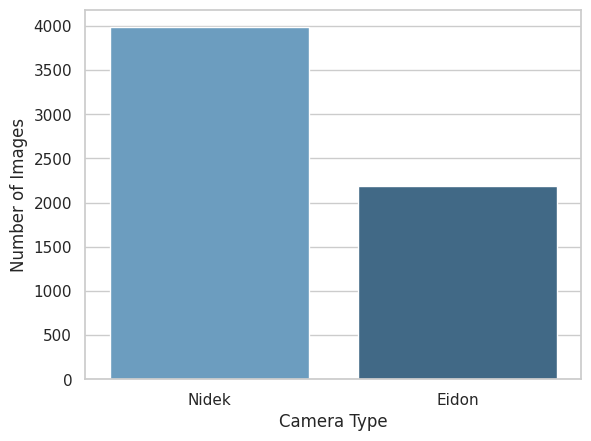

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d")
ax.set_xlabel("Camera Type")
ax.set_ylabel("Number of Images")
plt.show()


In [ ]:

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:

def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), correct / total

In [ ]:

def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(data_loader), correct / total

In [ ]:

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Skipping corrupted or unsupported image: /content/all_images/1878.jpg
Epoch [1/20], Train Loss: 0.0852, Train Acc: 0.9706, Val Loss: 0.0340, Val Acc: 0.9943
Skipping corrupted or unsupported image: /content/all_images/1878.jpg
Epoch [2/20], Train Loss: 0.0351, Train Acc: 0.9907, Val Loss: 0.0164, Val Acc: 0.9976
Skipping corrupted or unsupported image: /content/all_images/1878.jpg
Epoch [3/20], Train Loss: 0.0315, Train Acc: 0.9900, Val Loss: 0.0033, Val Acc: 0.9992
Skipping corrupted or unsupported image: /content/all_images/1878.jpg
Epoch [4/20], Train Loss: 0.0307, Train Acc: 0.9903, Val Loss: 0.0052, Val Acc: 1.0000
Skipping corrupted or unsupported image: /content/all_images/1878.jpg
Epoch [5/20], Train Loss: 0.0240, Train Acc: 0.9933, Val Loss: 0.0110, Val Acc: 0.9984
Skipping corrupted or unsupported image: /content/all_images/1878.jpg
Epoch [6/20], Train Loss: 0.0162, Train Acc: 0.9954, Val Loss: 0.0109, Val Acc: 0.9976
Skipping corrupted or unsupported image: /content/all_imag

In [ ]:
test_loss, test_acc = validate(model, val_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.0050, Test Acc: 0.9984


In [ ]:

model_save_path = '/content/drive/MyDrive/siriraj-eye-dataset/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/siriraj-eye-dataset/model.pth


In [ ]:

model_load_path = '/content/drive/MyDrive/siriraj-eye-dataset/camtype_model.pth'
loaded_model = models.resnet50(pretrained=True)
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, 1)
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.to(device)
loaded_model.eval()
print(f'Model loaded from {model_load_path}')

In [ ]:

test_loss, test_acc = validate(loaded_model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.0210, Test Acc: 0.9968
